# SNe Ia and Hubble Diagram

## Residual dependence on host galaxy properties

### Load SN data.

In [29]:
import numpy as np
import astropy.table as ast

LOWZ_table = ast.Table.read('./data/DES-SN5YR_LOWZ_HEAD.FITS')
DES_table = ast.Table.read('./data/DES-SN5YR_DES_HEAD.FITS')
Foundation_table = ast.Table.read('./data/DES-SN5YR_Foundation_HEAD.FITS')
source_table = ast.Table.read(
    './data/DES-Dovekie_HD.csv',
    format='csv',
    delimiter=' ',
    comment='#'
)

num_SN_samples = len(source_table)
print(f'Number of SNe samples: {num_SN_samples}')

LOWZ_table["SNID_str"] = [cid.strip() for cid in LOWZ_table["SNID"].astype(str)]
DES_table["SNID_str"] = [cid.strip() for cid in DES_table["SNID"].astype(str)]
Foundation_table["SNID_str"] = [
    cid.strip() for cid in Foundation_table["SNID"].astype(str)
]
source_table["CID_str"] = [cid.strip() for cid in source_table["CID"]]
source_table['ID'] = range(num_SN_samples) # Adding an ID column for reference

DES_sample = ast.join(
    source_table,
    DES_table,
    keys_left="CID_str",
    keys_right="SNID_str",
    join_type="inner",
)
LOWZ_sample = ast.vstack(
    [
        ast.join(
            source_table,
            LOWZ_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
        ast.join(
            source_table,
            Foundation_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
    ]
)
SN_sample = ast.vstack([DES_sample, LOWZ_sample], join_type="inner")
del SN_sample["SNID_str"], SN_sample["CID_str"]
SN_sample.sort('ID') # Restore the original order
SN_sample

Number of SNe samples: 1820


VARNAMES:,CID,IDSURVEY,zHD,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,PROBIA_BEAMS,ID,SNID,IAUC,FAKE,MASK_FLUXCOR_SNANA,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,REDSHIFT_QUALITYFLAG,MASK_REDSHIFT_SOURCE,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE
str3,str11,int64,float64,float64,float64,float64,float64,float64,float64,int64,bytes16,bytes16,int16,int16,float64,float64,float32,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,int16,int16,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SN:,Gaia16agf,150,0.02509,0.02507,35.25995,0.1773,0.0731,0.05631,1.0,0,Gaia16agf,2016aqs,0,0,98.537349,-25.1846,-9.0,-9,-9,1,32,3182,3213,0.0572,0.008,0.025068,2.5e-05,0.025533,2.5e-05,0,0,130.45,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,9.182,0.064,-1.99,0.87,-11.172,0.8723509,0.843,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-999.0,-999.0,57457.24,-9.0,-9.0,-9.0,-9
SN:,2003it,63,0.0251,0.02528,35.08017,0.1641,0.073,0.04157,1.0,1,2003it,2003it,0,0,1.45196,27.45267,-9.0,-9,-9,1,28,31337,31364,0.0608,0.003,0.025281,9e-06,0.024128,9e-06,0,0,-284.91,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,10.722,0.219,0.644,10.644,-10.078,10.646253,1.441,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-999.0,-999.0,52935.223,-9.0,-9.0,-9.0,-9
SN:,2007cq,64,0.0251,0.02604,34.98002,0.1331,0.073,0.03455,1.0,2,2007cq,2007cq,0,0,333.66846,5.08025,-9.0,-9,-9,1,111,28276,28386,0.0935,0.0047,0.026039,8e-05,0.024814,8e-05,0,0,-83.97,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,9.742,0.169,-0.278,0.751,-10.02,0.7697805,0.775,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999

In [58]:
import matplotlib.pyplot as plt

# Set global plotting font parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 20,

    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,

    "figure.titlesize": 20,
})

std_rc = plt.rcParams.copy()

### Hubble diagram

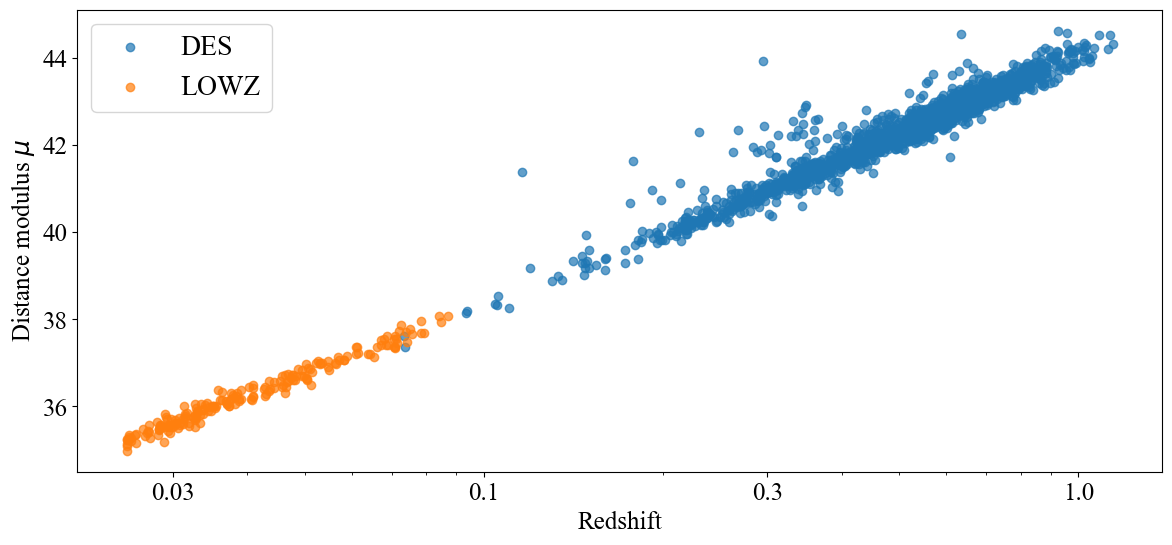

In [31]:
plt.figure(figsize=(14, 6))
plt.scatter(DES_sample['zHD'], DES_sample['MU'], label='DES', alpha=0.7)
plt.scatter(LOWZ_sample['zHD'], LOWZ_sample['MU'], label='LOWZ', alpha=0.7)
plt.xscale('log')
plt.xticks([0.03, 0.1, 0.3, 1.0], ['0.03', '0.1', '0.3', '1.0'])
plt.xlabel('Redshift')
plt.ylabel(r'Distance modulus $\mu$')
plt.legend()
plt.show()

#### SNe Redshift distribution

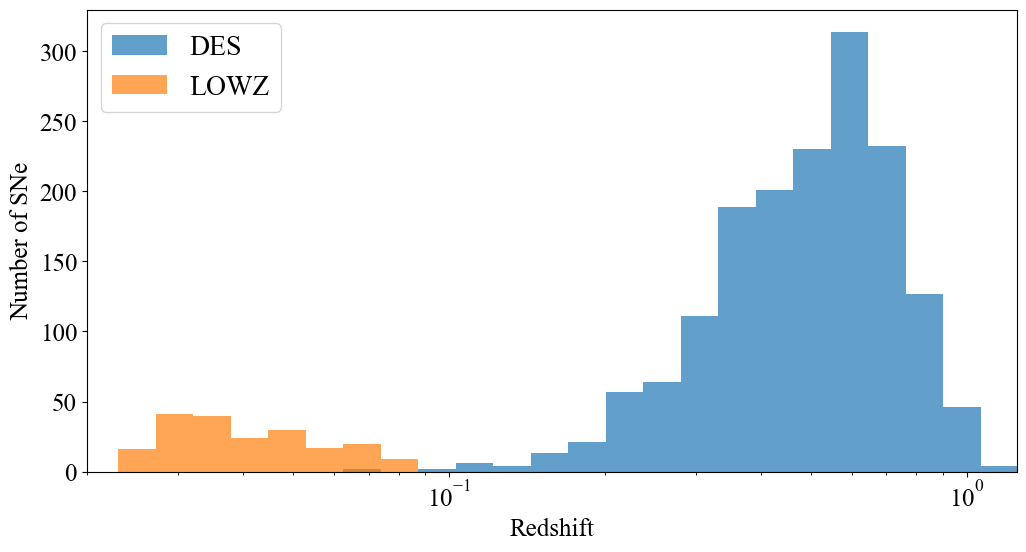

In [32]:
bins = np.logspace(-2, 0.1, 30)

plt.figure(figsize=(12, 6))
plt.hist(DES_sample['zHD'], bins=bins, label='DES', alpha=0.7)
plt.hist(LOWZ_sample['zHD'], bins=bins, label='LOWZ', alpha=0.7)
plt.xscale('log')
plt.xlabel('Redshift')
plt.ylabel('Number of SNe')
plt.xlim(0.02, 1.25)
plt.legend()
plt.show()

### Cosmology Fitting

#### Cosmology models

In [ ]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad

models = ["Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"]

def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) = H(z)/H0"""
    
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))

def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Luminosity distance under Flat ΛCDM model

    Args:
        z: redshift
        Omega_m: matter density parameter
        H0: Hubble constant (km/s/Mpc)

    Returns:
        luminosity distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0  # Hubble distance in Mpc

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    # Luminosity distance: dL = (1+z) * dC * dH
    return (1 + z) * dC * dH
def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Compute distance modulus for given cosmological model

    Args:
        z: redshift
        model: model name
            'Flat_LCDM': flat ΛCDM
            'Open_LCDM': open ΛCDM
            'Flat_wCDM': flat wCDM
            'Flat_w0waCDM': flat w0waCDM
        **kwargs: model parameters

    Returns:
        luminosity distance (Mpc)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        #"Open_LCDM": luminosity_distance_Open_LCDM,
        #"Flat_wCDM": luminosity_distance_Flat_wCDM,
        #"Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Unsupported model: {model}. Available: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

#### Set up sampler

In [68]:
import logging, sys
logger = logging.getLogger("ultranest")
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)
logger.setLevel(logging.WARNING)

In [69]:
from ultranest.integrator import ReactiveNestedSampler
from ultranest.utils import resample_equal
import scipy

# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_SN_samples, num_SN_samples))
indices = np.triu_indices(num_SN_samples)  # indices of upper triangle
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

L = np.linalg.cholesky(C_total)  # precompute Cholesky decomposition (for fast likelihood computation)

def prior_transform(cube, param_ranges):
    """
    Transform the unit hypercube [0,1]^d into the physical parameter space
    Parameters: [Omega_m, M]  (M is the combined parameter of absolute magnitude and H0)
    """
    params = np.zeros_like(cube)
    for i in range(len(param_ranges)):
        params[i] = (
            cube[i] * (param_ranges[i][1] - param_ranges[i][0]) + param_ranges[i][0]
        )
    return params


def log_likelihood(params, model="Flat_LCDM"):
    """
    Log-likelihood function: -0.5 * chi^2
    """
    M = params[-1]

    # Compute the theoretical distance modulus
    # (M is the absolute magnitude term in μ = 5 log10(dL) + 25 + M)
    mu_theory = np.array(
        [distance_modulus(z, params[:-1], model=model) + M for z in z_data]
    )

    residuals = mu_data - mu_theory
    if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
        return -1.0e99 * (np.abs(M) + 1)

    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    chi2 = np.sum(y**2)

    return -0.5 * chi2

def fit_cosmology(cosmology_model="Flat_LCDM"):
    """
    Fit cosmological parameters using UltraNest

    Args:
        cosmology_model:
            'Flat_LCDM': FlatΛCDM
            'Open_LCDM': OpenΛCDM
            'Flat_wCDM': FlatwCDM
            'Flat_w0waCDM': Flatw0waCDM

    Returns:
        sampling result object
    """
    param_names = {
        "Flat_LCDM": [r"$\Omega_m$", "M"],
        "Open_LCDM": [r"$\Omega_m$", r"$\Omega_k$", "M"],
        "Flat_wCDM": [r"$\Omega_m$", r"$w$", "M"],
        "Flat_w0waCDM": [r"$\Omega_m$", r"$w_0$", r"$w_a$", "M"],
    }
    param_ranges = {
        "Flat_LCDM": [(0.25, 0.4), (-20, 10)],
        "Open_LCDM": [(0.1, 0.5), (-1, 1), (-20, 10)],
        "Flat_wCDM": [(0.1, 0.4), (-2, 0.5), (-20, 10)],
        "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10), (-20, 10)],
    }

    sampler = ReactiveNestedSampler(
        param_names[cosmology_model],
        lambda params: log_likelihood(params, model=cosmology_model),
        lambda cube: prior_transform(cube, param_ranges[cosmology_model]),
    )

    result = sampler.run()
    return result

#### Fitting results

In [70]:
from getdist import MCSamples, plots
from ultranest.plot import cornerplot
import pickle
import os

def smooth_plot(result):
    samples = result['samples']  # (n_samples, n_params)
    weights = result['weighted_samples']['weights']

    # Exclude the last parameter
    param_names_all = result['paramnames']  # all parameter names

    # Create MCSamples object excluding the last parameter
    samples_mcd = MCSamples(
        samples=samples[:, :-1],  # Exclude the last column
        weights=weights,
        names=param_names_all[:-1],  # Exclude the last parameter name
        settings={'smooth_scale_2D': 0.8}  # Optional: smoothing parameter
    )

    # Plot the triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_mcd], filled=True)

fit_dir = 'fits'
os.makedirs(fit_dir, exist_ok=True)

##### Flat LCDM

In [71]:
Flat_LCDM_result = fit_cosmology("Flat_LCDM")
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_LCDM_result, f)

Corner plots

In [75]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 12,

    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,

    "figure.titlesize": 12,
})

Removed no burn in
Omega_m = 0.3299 +0.0155 -0.0163
M       = 5.0085 +0.0102 -0.0113


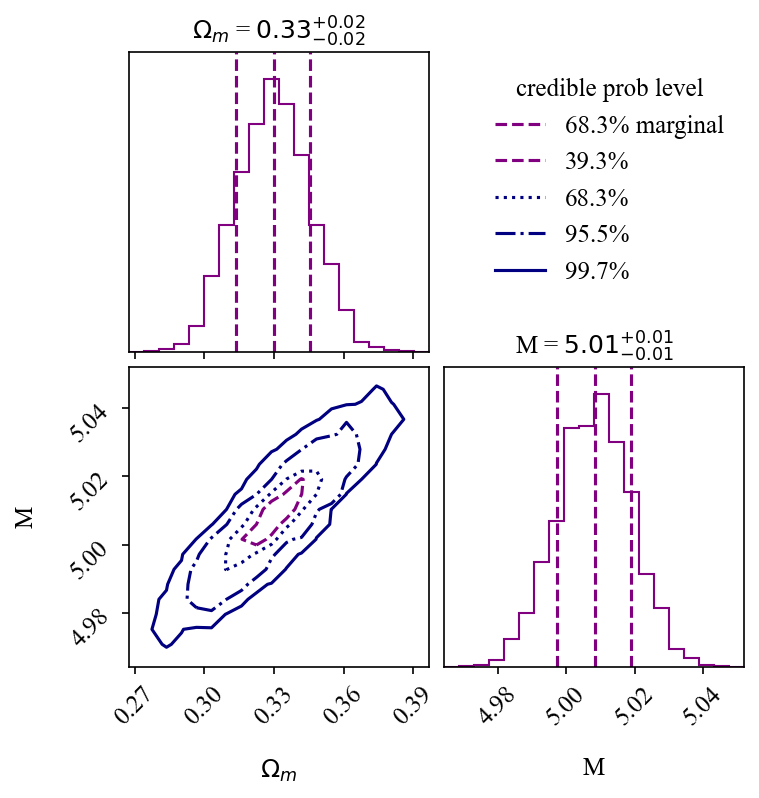

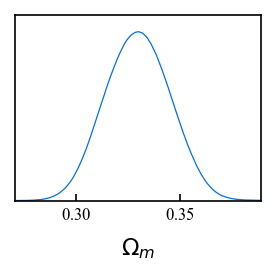

In [76]:
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)

cornerplot(Flat_LCDM_result)
smooth_plot(Flat_LCDM_result)

# Extract weighted posterior
samples   = Flat_LCDM_result["weighted_samples"]["points"]
weights   = Flat_LCDM_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16,       M_q50,       M_q84       = np.percentile(equal_samples[:, 1], [16, 50, 84])

print(f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
      f"-{Omega_m_q50 - Omega_m_q16:.4f}")
print(f"M       = {M_q50:.4f} +{M_q84 - M_q50:.4f} "
      f"-{M_q50 - M_q16:.4f}")

In [77]:
plt.rcParams.update(std_rc)

### Load host galaxy data

In [102]:
with open("./post_data/valid_host_galaxies.pkl", "rb") as f:
    data = pickle.load(f)

valid_SN_ids = data["valid_SN_ids"]
valid_host_galaxies = data["valid_host_galaxies"]

valid_host_galaxies[0]

ID,release,brickid,brickname,objid,brick_primary,maskbits,fitbits,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq,ebv,mjd_min,mjd_max,ref_cat,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_bp_n_obs,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_astrometric_weight_al,gaia_duplicated_source,gaia_a_g_val,gaia_e_bp_min_rp_val,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,apflux_g,apflux_r,apflux_z,apflux_resid_g,apflux_resid_r,apflux_resid_z,apflux_blobresid_g,apflux_blobresid_r,apflux_blobresid_z,apflux_ivar_g,apflux_ivar_r,apflux_ivar_z,apflux_masked_g,apflux_masked_r,apflux_masked_z,apflux_w1,apflux_w2,apflux_w3,apflux_w4,apflux_resid_w1,apflux_resid_w2,apflux_resid_w3,apflux_resid_w4,apflux_ivar_w1,apflux_ivar_w2,apflux_ivar_w3,apflux_ivar_w4,mw_transmission_g,mw_transmission_r,mw_transmission_z,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_g,nobs_r,nobs_z,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_g,fracflux_r,fracflux_z,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_g,fracmasked_r,fracmasked_z,fracin_g,fracin_r,fracin_z,anymask_g,anymask_r,anymask_z,allmask_g,allmask_r,allmask_z,wisemask_w1,wisemask_w2,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,nea_g,nea_r,nea_z,blob_nea_g,blob_nea_r,blob_nea_z,psfdepth_w1,psfdepth_w2,psfdepth_w3,psfdepth_w4,wise_coadd_id,wise_x,wise_y,lc_flux_w1,lc_flux_w2,lc_flux_ivar_w1,lc_flux_ivar_w2,lc_nobs_w1,lc_nobs_w2,lc_fracflux_w1,lc_fracflux_w2,lc_rchisq_w1,lc_rchisq_w2,lc_mjd_w1,lc_mjd_w2,lc_epoch_index_w1,lc_epoch_index_w2,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,dist,excluded_count,dr
int64,int16,int32,bytes8,int32,bool,int16,int16,bytes3,float64,float64,float32,float32,float32,float32,float32[5],float32,float64,float64,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32[15],float32[15],float32[15],float32[15],int16[15],int16[15],float32[15],float32[15],float32[15],float32[15],float64[15],float64[15],int16[15],int16[15],float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64
17,9010,407397,3347p132,3544,True,0,0,SER,334.7869083949392,13.177907597702697,10416741000000.0,1110286100

### Residuals and W1 band

#### Compute Hubble residuals for all SNe

In [ ]:
def flux_to_w1mag(flux_w1):
    """
    Convert WISE W1 flux (nanomaggies) to AB magnitude.
    Legacy Survey convention:
        m = 22.5 - 2.5 * log10(flux)
    """
    if flux_w1 <= 0 or np.isnan(flux_w1):
        return np.nan
    return 22.5 - 2.5 * np.log10(flux_w1)

z_all = SN_sample['zHD'].data
mu_obs_all = SN_sample['MU'].data

# Model distance modulus for Flat ΛCDM
mu_model_all = np.array([
    distance_modulus(z, [Omega_m_q50], model='Flat_LCDM') + M_q50
    for z in z_all
])

# Hubble residuals: Δμ = μ_obs − μ_model
residual_all = mu_obs_all - mu_model_all

#### Select SNe with valid host galaxies and W1 flux

In [80]:
SN_ids = []
W1_mag = []
residuals = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]

    # Require W1 flux measurement
    if 'flux_w1' not in host.colnames:
        continue

    flux_w1 = host['flux_w1'][0]
    w1_mag = flux_to_w1mag(flux_w1)

    # Remove invalid values
    if np.isnan(w1_mag):
        continue

    SN_ids.append(SN_id)
    W1_mag.append(w1_mag)
    residuals.append(residual_all[SN_id])

SN_ids = np.array(SN_ids)
W1_mag = np.array(W1_mag)
residuals = np.array(residuals)

print(f"Final sample size used in residual–W1 analysis: {len(W1_mag)}")

Final sample size used in residual–W1 analysis: 1091


#### Hubble residuals vs W1 magnitude: linear trend test

Linear trend: Δμ = (0.0137) × W1 + (-0.2260)


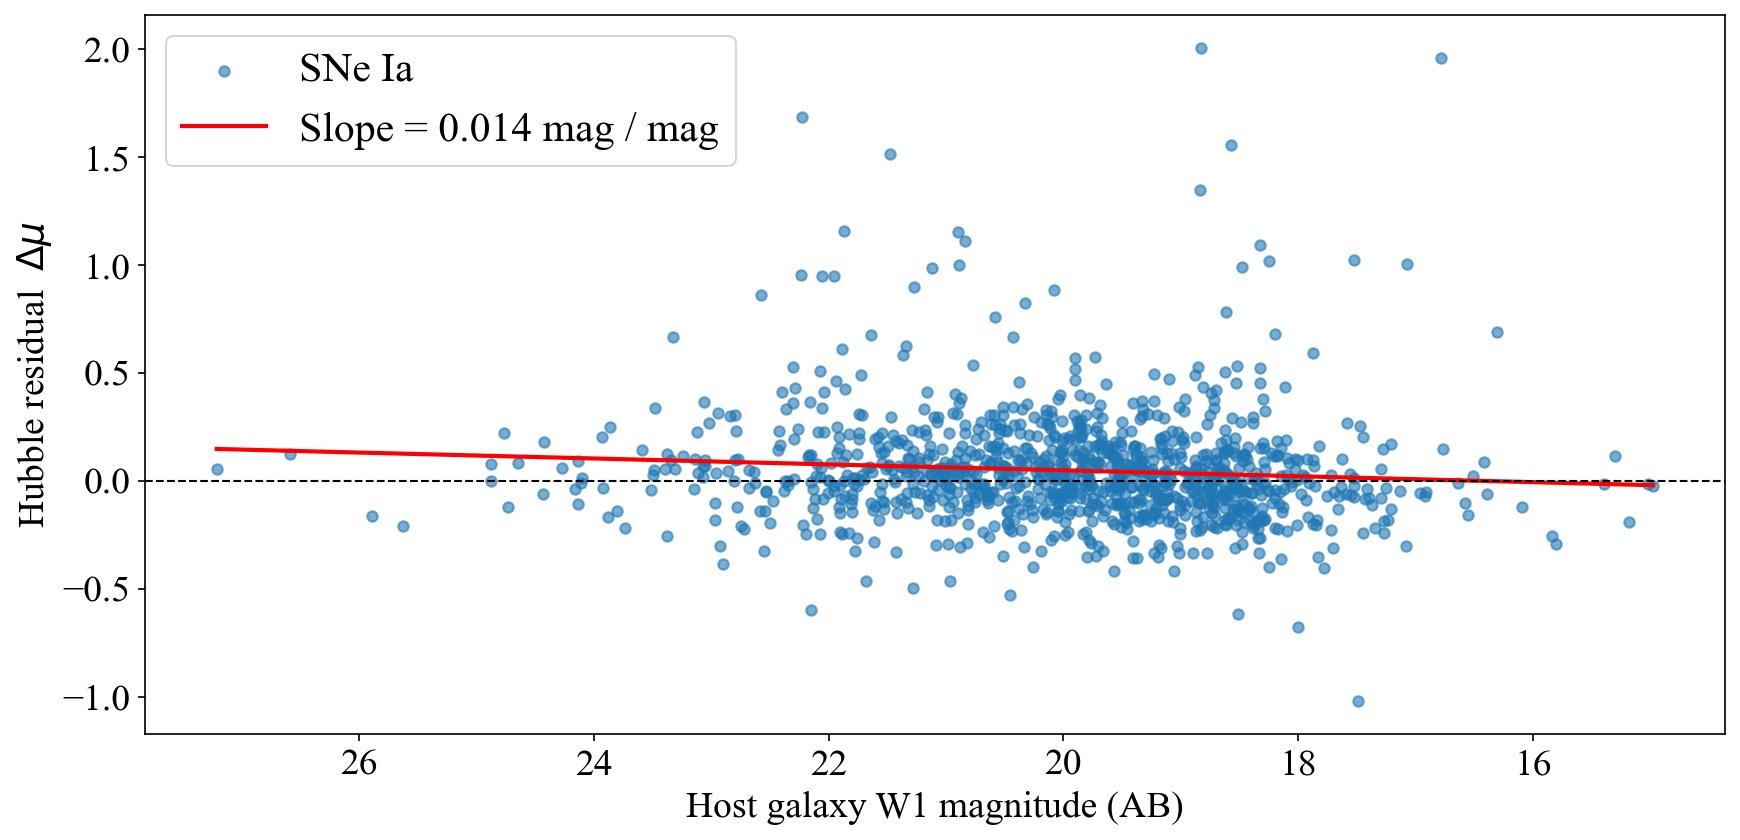

In [82]:
coef = np.polyfit(W1_mag, residuals, 1)
slope, intercept = coef

xfit = np.linspace(W1_mag.min(), W1_mag.max(), 200)
yfit = slope * xfit + intercept

print(f"Linear trend: Δμ = ({slope:.4f}) × W1 + ({intercept:.4f})")

plt.figure(figsize=(12, 6))
plt.scatter(W1_mag, residuals, s=25, alpha=0.6, label='SNe Ia')
plt.plot(
    xfit, yfit,
    color='r', lw=2,
    label=f'Slope = {slope:.3f} mag / mag'
)

plt.axhline(0.0, color='k', ls='--', lw=1)
plt.xlabel('Host galaxy W1 magnitude (AB)')
plt.ylabel(r'Hubble residual  $\Delta\mu$')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
mu_err = SN_sample['MUERR'].data[SN_ids]

from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

sigma_eff = np.sqrt(mu_err**2 + 0.1**2)  # intrinsic scatter included

popt, pcov = curve_fit(
    linear_model,
    W1_mag,
    residuals,
    sigma=sigma_eff,
    absolute_sigma=True
)

slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])

print(f"Slope = {slope:.4f} ± {slope_err:.4f}")
print(f"Significance = {abs(slope)/slope_err:.2f} sigma")

Slope = 0.0122 ± 0.0036
Significance = 3.35 sigma


Pearson r (residual vs z) = -0.034
p-value = 2.55e-01


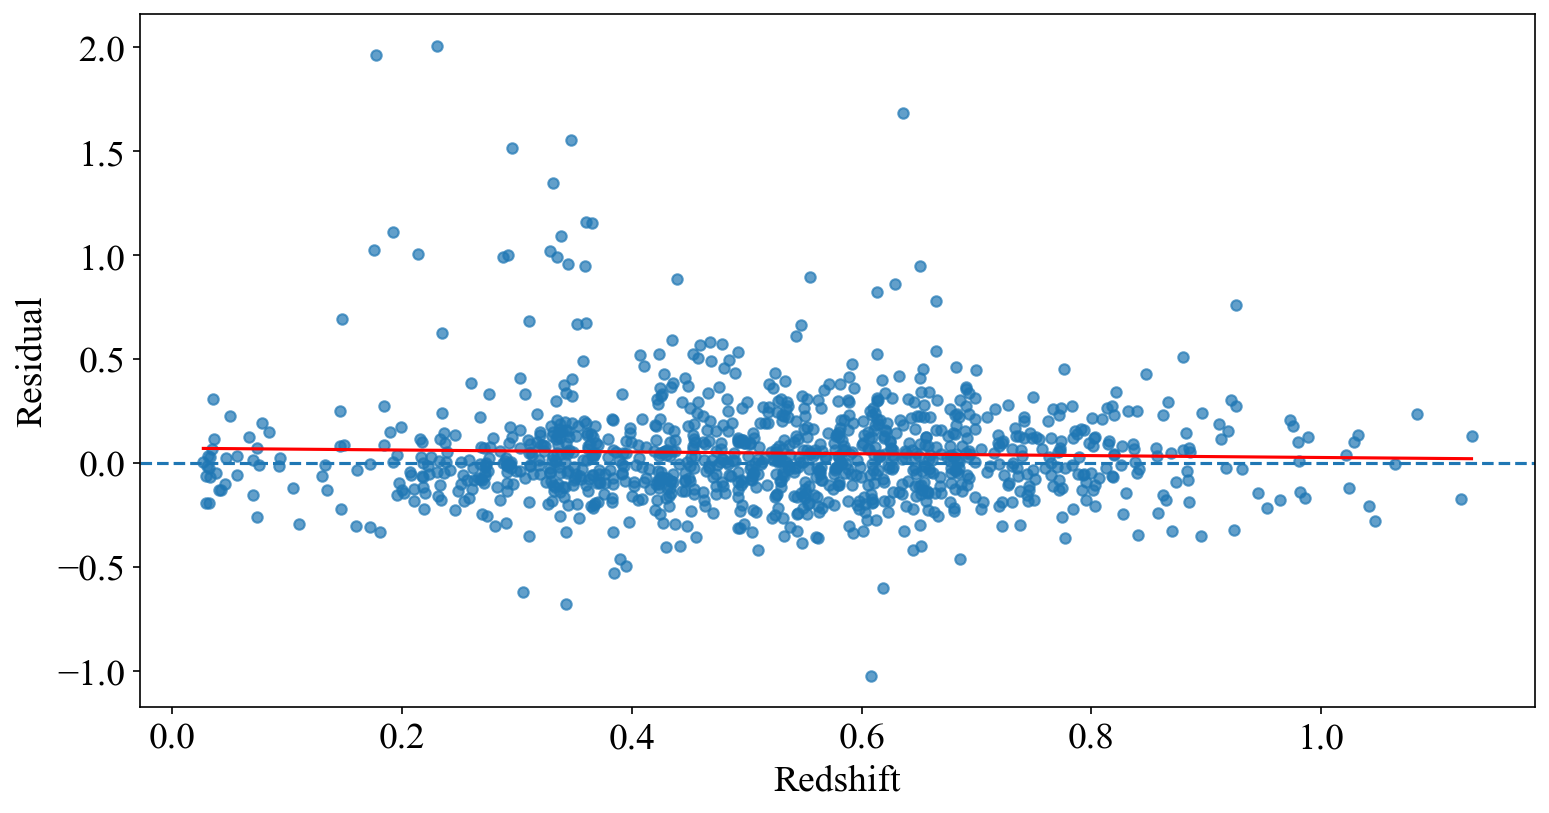

In [96]:
from scipy.stats import pearsonr

z = z_all[SN_ids]
r_res_z, p_res_z = pearsonr(z, residuals)

print(f"Pearson r (residual vs z) = {r_res_z:.3f}")
print(f"p-value = {p_res_z:.2e}")

plt.figure(figsize=(12, 6))
plt.scatter(z_all[SN_ids], residuals, s=25, alpha=0.7)
plt.axhline(0, ls='--')
p = np.polyfit(z, residuals, 1)
plt.plot(z, np.polyval(p, z), color='r')
plt.xlabel('Redshift')
plt.ylabel('Residual')
plt.show()

CMT: We find no correlation between Hubble residuals and redshift.

Pearson r (W1 vs z) = 0.164
p-value = 4.94e-08


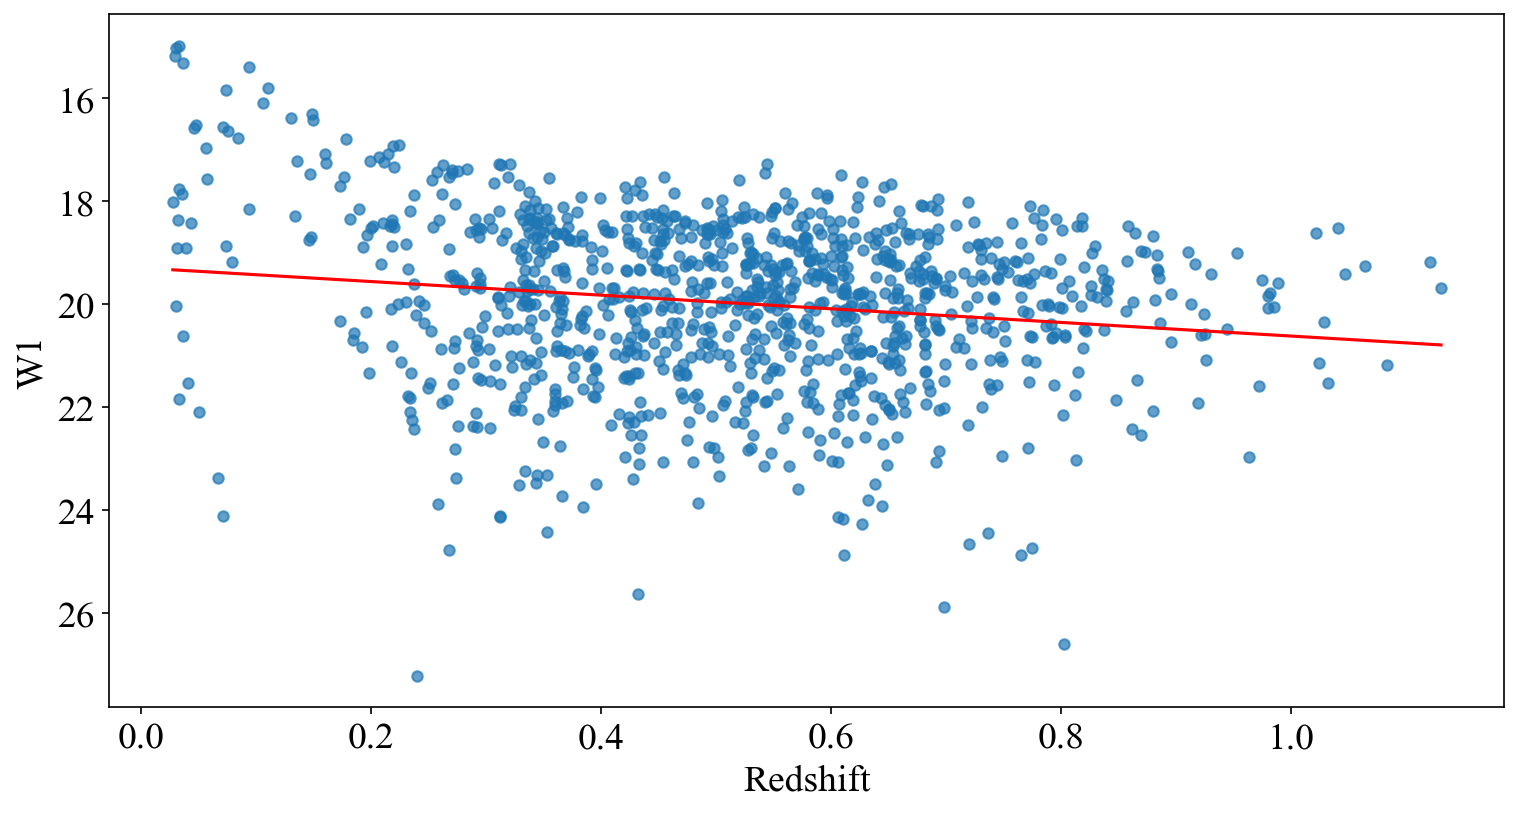

In [94]:
r_w1_z, p_w1_z = pearsonr(z, W1_mag)

print(f"Pearson r (W1 vs z) = {r_w1_z:.3f}")
print(f"p-value = {p_w1_z:.2e}")

plt.figure(figsize=(12, 6))
plt.scatter(z_all[SN_ids], W1_mag, s=25, alpha=0.7)
p = np.polyfit(z, W1_mag, 1)
plt.plot(z, np.polyval(p, z), color='r')
plt.xlabel('Redshift')
plt.ylabel('W1')
plt.gca().invert_yaxis()
plt.show()

CMT: Host galaxy W1 magnitude shows a strong dependence on redshift, consistent with selection effects.

In [100]:
z = z_all[SN_ids]

z_bins = [0.01, 0.1, 0.2, 0.4, 0.8, 1.0]
z_idx = np.digitize(z, z_bins)

for i in range(1, len(z_bins)):
    mask = z_idx == i
    if np.sum(mask) < 30:
        continue

    slope_i, intercept_i = np.polyfit(
        W1_mag[mask],
        residuals[mask],
        1
    )

    print(f"z bin {z_bins[i-1]}–{z_bins[i]}: slope = {slope_i:.4f}")

z bin 0.01–0.1: slope = 0.0186
z bin 0.2–0.4: slope = 0.0124
z bin 0.4–0.8: slope = 0.0152
z bin 0.8–1.0: slope = 0.0417


In [101]:
from sklearn.linear_model import LinearRegression

X = np.vstack([W1_mag, z]).T
y = residuals
reg = LinearRegression().fit(X, y)

print(f"Δμ = {reg.coef_[0]:.4f} W1 + {reg.coef_[1]:.4f} z + {reg.intercept_:.4f}")

Δμ = 0.0150 W1 + -0.0648 z + -0.2190


#### Hubble residuals vs W1-W2 color: linear trend test

In [104]:
SN_ids = []
W1W2_color = []
residuals = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]

    # Require both W1 and W2 flux measurements
    if 'flux_w1' not in host.colnames or 'flux_w2' not in host.colnames:
        continue

    flux_w1 = host['flux_w1'][0]
    flux_w2 = host['flux_w2'][0]

    w1_mag = flux_to_w1mag(flux_w1)
    w2_mag = flux_to_w1mag(flux_w2)

    # Remove invalid values
    if np.isnan(w1_mag) or np.isnan(w2_mag):
        continue

    SN_ids.append(SN_id)
    W1W2_color.append(w1_mag - w2_mag)  # W1-W2 color
    residuals.append(residual_all[SN_id])

SN_ids = np.array(SN_ids)
W1W2_color = np.array(W1W2_color)
residuals = np.array(residuals)

print(f"Final sample size used in residual–W1-W2 analysis: {len(W1W2_color)}")

Final sample size used in residual–W1-W2 analysis: 959


Slope (Δμ vs W1-W2) = -0.0049 ± 0.0088
Significance = 0.55 sigma


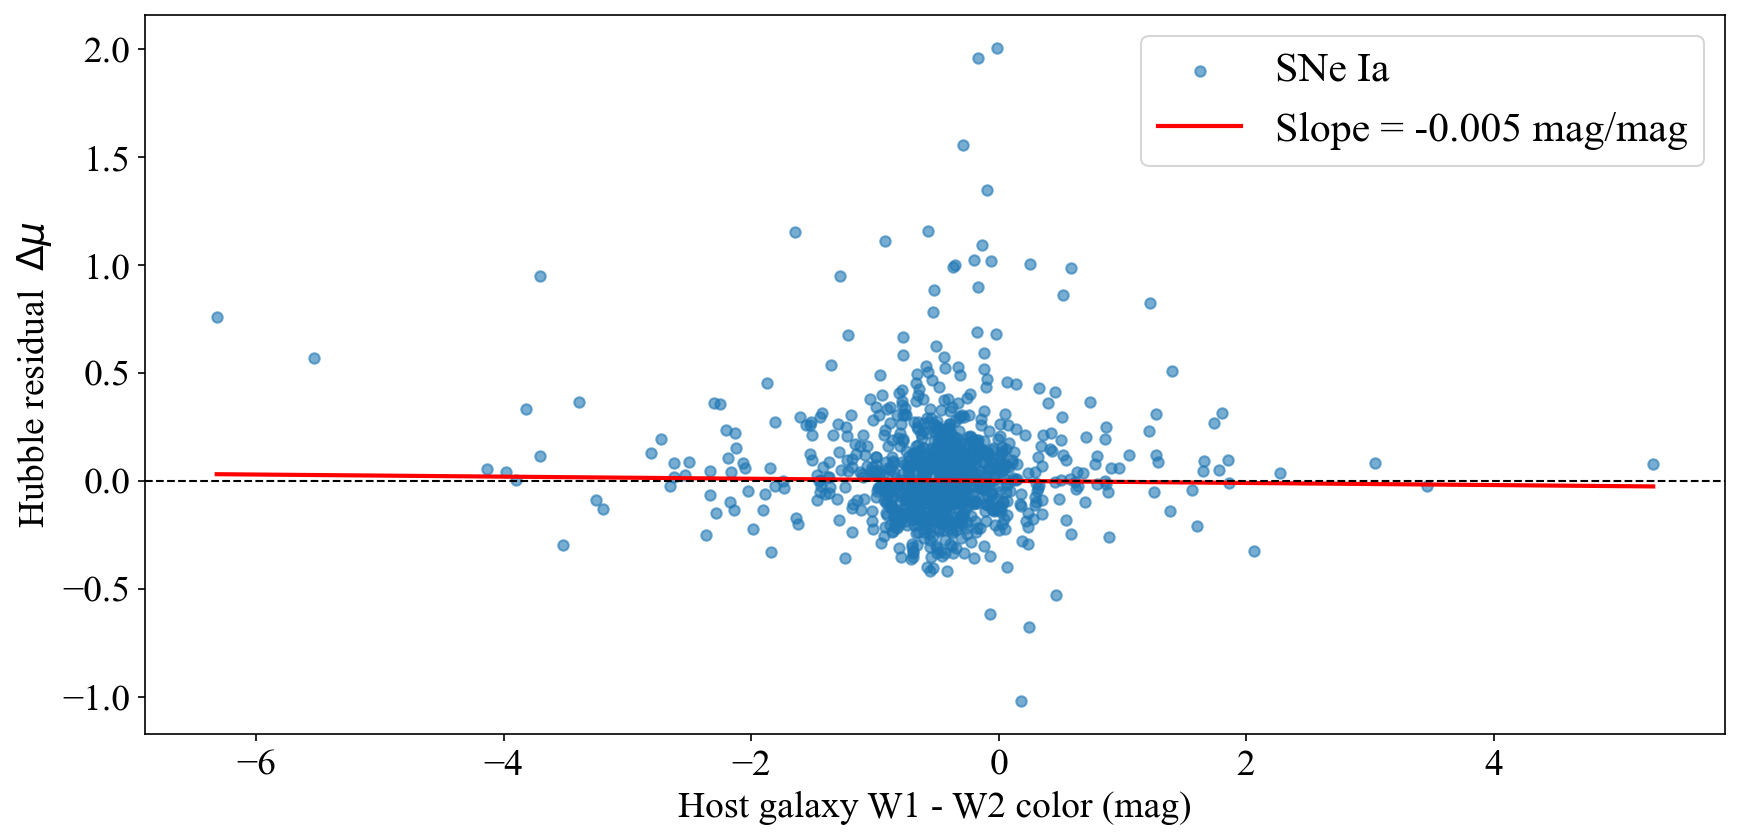

In [105]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

mu_err = SN_sample['MUERR'].data[SN_ids]
sigma_eff = np.sqrt(mu_err**2 + 0.1**2)  # intrinsic scatter

popt, pcov = curve_fit(
    linear_model,
    W1W2_color,
    residuals,
    sigma=sigma_eff,
    absolute_sigma=True
)

slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])

print(f"Slope (Δμ vs W1-W2) = {slope:.4f} ± {slope_err:.4f}")
print(f"Significance = {abs(slope)/slope_err:.2f} sigma")

import matplotlib.pyplot as plt
import numpy as np

xfit = np.linspace(W1W2_color.min(), W1W2_color.max(), 200)
yfit = slope * xfit + intercept

plt.figure(figsize=(12, 6))
plt.scatter(W1W2_color, residuals, s=25, alpha=0.6, label='SNe Ia')
plt.plot(xfit, yfit, color='r', lw=2, label=f'Slope = {slope:.3f} mag/mag')
plt.axhline(0.0, color='k', ls='--', lw=1)
plt.xlabel('Host galaxy W1 - W2 color (mag)')
plt.ylabel(r'Hubble residual  $\Delta\mu$')
plt.legend()
plt.tight_layout()
plt.show()

CMT: We find no correlation between Hubble residuals and host galaxy W1-W2 color.